<a href="https://colab.research.google.com/github/anubhavsatpathy/EVA/blob/master/Session10/EVA_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Session 10 assignment:

This assignment asks us to do the following:

- Take the [gradcam code](https://colab.research.google.com/drive/10GugXUNI7ztK2joRZUnYyqRrQbYnOQE0#scrollTo=UrKWie4LiSWV) shared in the module handout
-Load the VGG16 model pre-trained on the image net dataset
- Use the dog image in the link above
- Print the gradCAM output for that image but the last 2 penultimage convolution layers
- Load and preprocess [this](https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg) image
- Use gradCAM in order to find the sunglasses in the image

###Importing libraries and modules

- **keras.applications :** Keras Applications has a few canned models that are pre-trained on a few famous datasets like CIFAR10, ImageNet etc.

- **cv2_imshow** : The normal imshow() method of cv2 does not work with google colab notebooks and hence this is a patch for that method

We import the **VGG16** model and the methods **preprocess_input** and **decode_predictions** that help us normalize and preprocess the input by imagenet standards and decode the predictions as per ImageNet class Names

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras import backend as K
import numpy as np
from skimage import io
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

###Loading the model:

In the code below, we:

- Load the **VGG16** model pre-trained on the **ImageNet** dataset
- We read the Dog image from the specified link
- We resize it to *224x224* as per imagenet standards
- We convert the image to a numpy array
- We convert it to a 4D tensor of shape [1, 224, 224, 3] so that it can qualify as a valid input for the model
- We normalize the image as per imagenet standards - Subtract the mean and Divide by the Standard deviation
- We print the image to the console
- We print the summary of the VGG16 model

(1, 224, 224, 3)


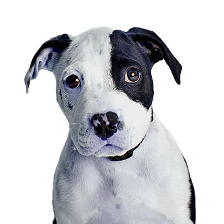

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
model = VGG16(weights="imagenet")
dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)
cv2_imshow(dog)
model.summary()

###Defining gradCAM function

This function takes the following arguments:

- **x** : This is the pre-processed image (4D tensor) that would be passed through the model
- **model** : Here we passs the model to be used to generate the gradcam image from
- **layer_name** : We generate the gradCAM heatmaps for this layer
- **image** : This is the unprocessed image used to superimpose the heatmap
- **class_id** : This is the class for which the gradCAM heatmap is being generated for - If set to None the heatmaps are generated for the class that the model predicted

This function does the following:

- **Generates gradCAM heatmaps** : 
  - Takes the gradients of the layer passed as argument to the class ID passed as argument
  -If no class ID is passed it uses the predicted class ID
  - performs GAP on this gradients
  - Takes a weighted sum of the channels in the layer using the GAP output as weights
  - Peforms ReLU on this
  - Resizes the image thus obtained to 224x224
  - Applies a cv2 heatmap to convert the B/W image to a RGB image representative of the intensities
  

- **Prints the super-imposed image**:
  - Uses cv2_imshow() to print the unprocessed image to the console
  - Uses cv2.addWeighted() method to super-impose the heatmap onto the image
  - Prints this super-imposed image to the console

In [0]:
def get_gradcam_img(x, model, layer_name, image, class_id = None):
  preds = model.predict(x)
  if class_id is None:
    class_idx = np.argmax(preds[0])
  else:
    class_idx = class_id
  #print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  #print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  #print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  #print(conv_layer_output_value.shape)
  #print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
  cv2_imshow( image)
  cv2_imshow(superimposed_img)


###gradCAM of the Layer Before:

The code had used the layer named **block5_conv3** to generate gradCAM images

Hence we pass **block5_conv2** as required by the assignment to our function

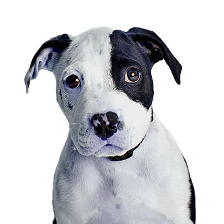

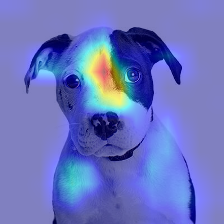

In [21]:
get_gradcam_img(x, model, "block5_conv2", dog)

###Aaaandd the layer before that one ..

Next we pass the layer before that one viz. **block5_conv1**

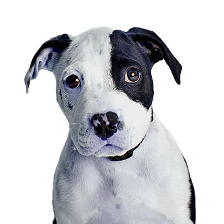

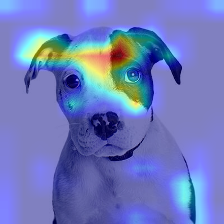

In [22]:
get_gradcam_img(x, model, "block5_conv1", dog)

###Observations : 

As we go deeper into the network - the layers start looking at specific parts of the image for specific classes

The heatmap is more spread out in the shallower layers since they are looking for more generic features

###And I am Iron Man:

Being a huge tony stark fanboy - I have wanted to say that iconic line ever since I've seen the climax of the Endgame. Alright - Now that that is done - this is what the code below does:

1. **Uploads the file to the runtime** since the link provided forbid downloading the image
2. **Resizes** the image to *224x224*
3. **Convert it to a 4D tensor** of shape [1, 224, 224, 3] so that it can qualify as a valid input for the model
4. **Preprocess** the image as per image net standards
5. Prints the image to the console

(1, 224, 224, 3)


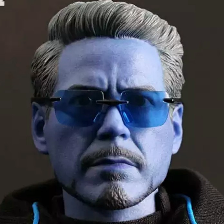

In [33]:
stark = io.imread("/content/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg")
stark = cv2.resize(stark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(stark)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)
cv2_imshow(stark)
#model.summary()

### Finding Stark's Sunglasses:

The gradCAM ClassIDs as listed [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) enlist :
- **836** : sunglass
- **837** : sunglasses, dark glasses, shades

Hence, we pass the same Class IDs to our gradCAM function defined above to generate heatmaps for the sunglasses and thereafter superimpose them on the original image

Results below

**Please note that in order to replicate results - you have to :**
- Download the image to your local
- Upload it to the runtime
- Rightclick and copy path
- Use that path in the io.imread() method above

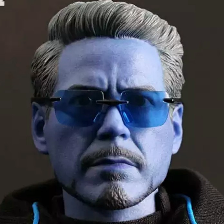

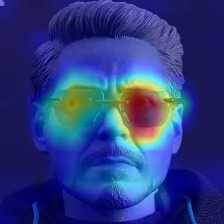

In [28]:
get_gradcam_img(x, model, "block5_conv3", stark, 837)

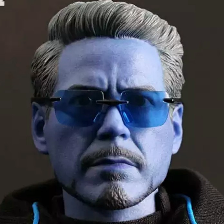

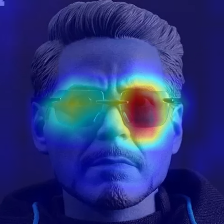

In [29]:
get_gradcam_img(x, model, "block5_conv3", stark, 836)